In [1]:
from mistune.plugins.table import table_in_list

'''
Este script para determianr parámetros con el MACD. Va a descargar datos de yahoo para facilitar mientras hago el downloader de IB

'''

'\nEste script para determianr parámetros con el MACD. Va a descargar datos de yahoo para facilitar mientras hago el downloader de IB\n\n'

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm, skew, kurtosis

# Para que los gráficos se vean en el notebook
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
#inicialización
# Obtener los datos históricos de precios de una acción utilizando yfinance
ACCION= 'MO'
FechaIni= '2024-01-01'
FechaFin= '2025-10-10'
data = yf.download(ACCION, start=FechaIni, end=FechaFin, auto_adjust=False)


[*********************100%***********************]  1 of 1 completed


In [4]:
# Calculo macd with standard colors first
# Calculo con precio de cierre
#macd = data.Close.ewm(span=12).mean() - data.Close.ewm(span=26).mean()
# Calculo con precio de cierre ajustado
macd = data['Adj Close'].ewm(span=12).mean() - data['Adj Close'].ewm(span=26).mean()

signal = macd.ewm(span=9).mean()
histogram = macd - signal

# Agregar el MACD al dataframe
data['MACD'] = macd
data['Signal'] = signal
data['Histograma']= histogram


In [5]:
#Calculo el cruce, en función del cambio del signo de la columna Histograma, para ello desplazo la columna histograma una posición y relaizo l amultiplicación.
#Si el resultado es negativo indica que ha habido un cruce. Una vez hehco esto lo cambio para tener una lógica positiva

data['Cruce']= np.sign(data['Histograma'] * data['Histograma'].shift(1))


# Inicializamos la columna de salida
data['Estado'] = 'reposo'

# Condiciones para posiciones largas
cond_largo = (
    (data['Cruce'] == -1) &
    (data['Histograma'] > 0) &
    (data['MACD'] < 0) &
    (data['Signal'] < 0)
)

# Condiciones para posiciones cortas
cond_corto = (
    (data['Cruce'] == -1) &
    (data['Histograma'] < 0) &
    (data['MACD'] > 0) &
    (data['Signal'] > 0)
)

# Aplicamos las condiciones
data.loc[cond_largo, 'Estado'] = 'largo'
data.loc[cond_corto, 'Estado'] = 'corto'

In [15]:
#Voy a determinar cuales son los indices donde se abre posición.

indices = data.index[data['Estado'] != 'reposo']



In [16]:
# ---------------------------
# Cálculo de retornos diarios hasta 30 días
# ---------------------------


resultados = []
resumen = []

# Tomamos todos los cruces
for idx, row in data[data['Estado'] != 'reposo'].iterrows():
    # precio_inicio = row['Adj Close']

    estado = row['Estado']
    estado = estado.iloc[0] if isinstance(estado, pd.Series) else estado
    fecha_inicio = idx

    # Localizamos la posición del índice
    idx_pos = data.index.get_loc(idx)

    # Creamos la ventana de 31 días (día 0 + 30 siguientes)
    ventana_w = data.iloc[idx_pos: idx_pos + 31]
    ventana= ventana_w.iloc[1:]

    if len(ventana_w) < 2:
        continue  # si no hay suficientes días, saltamos

    # Retornos relativos día a día respecto al precio del cruce
    precio_inicios = ventana_w['Adj Close'].iloc[0]
    precio_inicio = precio_inicios.iloc[0]
    retornos = (ventana['Adj Close'].values - precio_inicio) / precio_inicio
    retornos = np.ravel(retornos)

    # Crear DataFrame temporal
    df_temp = pd.DataFrame({
        'Fecha_inicio': [fecha_inicio] * len(ventana),
        'Fecha': ventana.index,
        'Estado': [estado] * len(ventana),
        'Dia': np.arange(len(ventana)),
        'Retorno': retornos
    })

    resumen.append({
        'Fecha_inicio': fecha_inicio,
        'Estado': estado,
        'Media_retorno': np.mean(retornos),
        'Mediana_retorno': np.median(retornos),
        'Desviacion_tipica': np.std(retornos),
        'Max_excursion': np.max(retornos),
        'Min_excursion': np.min(retornos),
        'Percentil_90': np.percentile(retornos, 90)
    })

    resultados.append(df_temp)

    # Calcular estadísticas por cada cruce
    
    
# Unir todos los resultados
df_resultados = pd.concat(resultados, ignore_index=True)
df_resumen = pd.DataFrame(resumen)
 
# Agrupar por 'Estado' y calcular las medias y medianas deseadas
resumen_estado = df_resumen.groupby('Estado').agg({
    'Media_retorno': ['mean', 'median'],
    'Mediana_retorno': ['mean', 'median'],
    'Max_excursion': ['mean', 'median'],
    'Min_excursion': ['mean', 'median'],
    'Desviacion_tipica': ['mean', 'median']
})

# Opcional: mejorar la presentación de las columnas
resumen_estado.columns = [
    'Media(Media_retorno)', 'Mediana(Media_retorno)',
    'Media(Mediana_retorno)', 'Mediana(Mediana_retorno)',
    'Media(Max_excursion)', 'Mediana(Max_excursion)',
    'Media(Min_excursion)', 'Mediana(Min_excursion)',
    'Media(Desviacion_tipica)','Mediana(Desviacion_tipica)'
]
    
print(resumen_estado)




        Media(Media_retorno)  Mediana(Media_retorno)  Media(Mediana_retorno)  \
Estado                                                                         
corto               0.017410                0.013663                0.017897   
largo               0.043219                0.056011                0.045076   

        Mediana(Mediana_retorno)  Media(Max_excursion)  \
Estado                                                   
corto                   0.011828              0.060273   
largo                   0.045401              0.102603   

        Mediana(Max_excursion)  Media(Min_excursion)  Mediana(Min_excursion)  \
Estado                                                                         
corto                 0.053036             -0.020539               -0.013685   
largo                 0.113464             -0.018197               -0.012823   

        Media(Desviacion_tipica)  Mediana(Desviacion_tipica)  
Estado                                                        

In [17]:
# Extraemos los valores deseados
valores = {
    'largo': {
        'Mediana': resumen_estado.loc['largo', 'Mediana(Media_retorno)'],
        'Desviacion': resumen_estado.loc['largo', 'Mediana(Desviacion_tipica)']
    },
    'corto': {
        'Mediana': resumen_estado.loc['corto', 'Mediana(Media_retorno)'],
        'Desviacion': resumen_estado.loc['corto', 'Mediana(Desviacion_tipica)']
    }
}


In [18]:
# Obtener el último valor de cotización
precio_actual = data["Adj Close"].iloc[-1]
precio_actual = precio_actual.values[0]

for estado in resumen_estado.index: # recorre 'largo' y 'corto'
    # Extraer valores de cada estado
    mediana_ret = resumen_estado.loc[estado, 'Mediana(Media_retorno)' ]
    mediana_std = resumen_estado.loc[estado, 'Mediana(Desviacion_tipica)']

    # Sumar las métricas
    if estado == 'largo':
        suma_metricas = mediana_ret - mediana_std
        resultado = precio_actual-(suma_metricas * precio_actual)
    else:
        suma_metricas = mediana_ret + mediana_std
        resultado = (suma_metricas * precio_actual) + precio_actual

    # Aplicar la fórmula
    #resultado = (suma_metricas * precio_actual) + precio_actual

    print(f"Estado: {estado.upper()}")
    print(f"  ▸ Mediana retorno: {mediana_ret:.6f}")
    print(f"  ▸ Mediana desviación típica: {mediana_std:.6f}")
    print(f"  ▸ Suma métricas: {suma_metricas:.6f}")
    print(f"  ▸ Proyección: {resultado:.2f}\n")


Estado: CORTO
  ▸ Mediana retorno: 0.013663
  ▸ Mediana desviación típica: 0.022961
  ▸ Suma métricas: 0.036624
  ▸ Proyección: 68.13

Estado: LARGO
  ▸ Mediana retorno: 0.056011
  ▸ Mediana desviación típica: 0.032750
  ▸ Suma métricas: 0.023261
  ▸ Proyección: 64.19




===== ESTADÍSTICAS GLOBALES =====
Media global: 0.008979
Mediana global: 0.004979
Desviación típica global: 0.057730
Máxima excursión: 0.213242
Mínima excursión: -0.272938
Percentil 90: 0.084558
Asimetría (Skew): -0.275967
Curtosis: 1.919999

===== RETORNOS POSITIVOS =====
Media: 0.046534
Mediana: 0.034582
Desviación típica: 0.039727

===== RETORNOS NEGATIVOS =====
Media: -0.039671
Mediana: -0.027799
Desviación típica: 0.041056

===== RESUMEN POR CRUCE =====


,Fecha_inicio,Estado,Media_retorno,Mediana_retorno,Desviacion_tipica,Max_excursion,Min_excursion,Percentil_90
0,2019-01-30,largo,0.075692,0.056695,0.055588,0.179916,0.000000,0.166318
1,2019-03-22,corto,-0.013597,-0.014485,0.026902,0.032367,-0.080651,0.018240
2,2019-05-22,largo,-0.045649,-0.049593,0.024764,0.000000,-0.089612,-0.012872
3,2019-06-07,largo,-0.022129,-0.022404,0.021553,0.014986,-0.063919,0.005471
4,2019-07-05,largo,-0.010462,0.000000,0.032729,0.035876,-0.067445,0.025830
5,2019-08-21,largo,-0.063089,-0.054270,0.040362,0.018811,-0.115836,0.000000
6,2019-09-11,largo,-0.036278,-0.042737,0.040675,0.065525,-0.085586,0.010368
7,2019-09-30,largo,0.082364,0.095110,0.050983,0.148166,-0.016871,0.134718
8,2019-11-04,corto,0.066957,0.079386,0.037511,0.114693,0.000000,0.108114
9,2019-11-14,corto,0.070188,0.075702,0.026253,0.105512,0.000000,0.098753


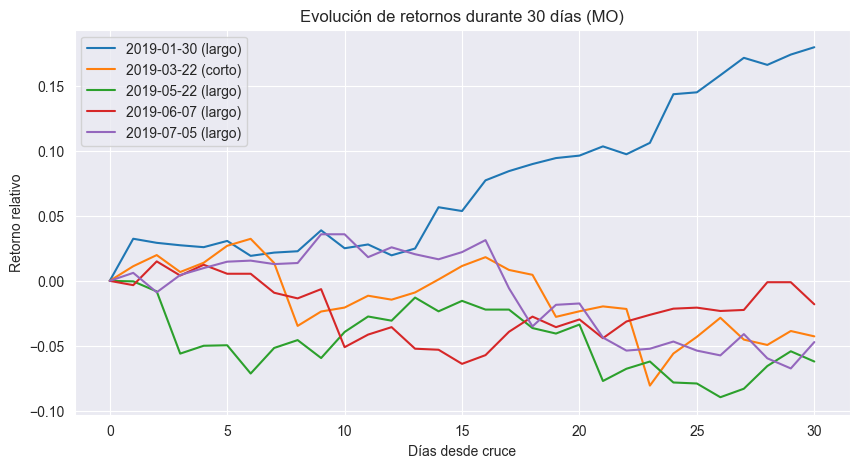

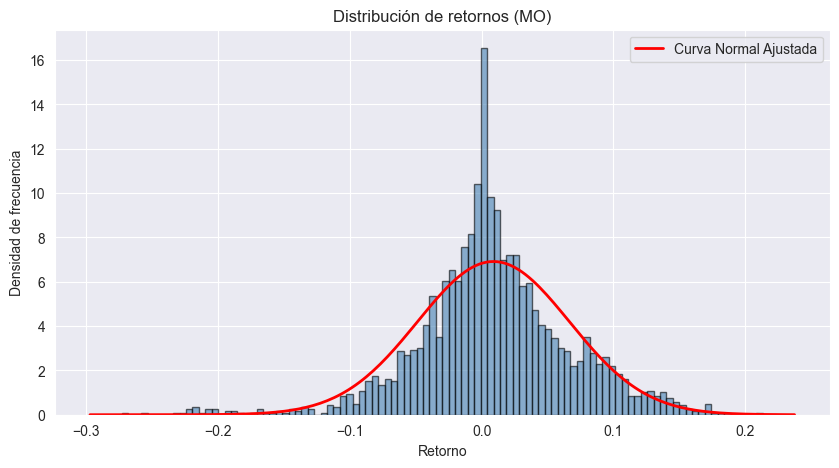

In [17]:
#-------------- Estadísticas Globales --------------------------------
retornos_globales = df_resultados['Retorno']

media_global = retornos_globales.mean()
mediana_global = retornos_globales.median()
std_global = retornos_globales.std()
max_excursion = retornos_globales.max()
min_excursion = retornos_globales.min()
percentil_90 = np.percentile(retornos_globales, 90)
asimetria = skew(retornos_globales, nan_policy='omit')
curtosis_val = kurtosis(retornos_globales, nan_policy='omit')

# Separar positivos y negativos
retornos_pos = retornos_globales[retornos_globales > 0]
retornos_neg = retornos_globales[retornos_globales < 0]

media_pos = retornos_pos.mean()
mediana_pos = retornos_pos.median()
std_pos = retornos_pos.std()

media_neg = retornos_neg.mean()
mediana_neg = retornos_neg.median()
std_neg = retornos_neg.std()

# Mostrar resultados
print("\n===== ESTADÍSTICAS GLOBALES =====")
print(f"Media global: {media_global:.6f}")
print(f"Mediana global: {mediana_global:.6f}")
print(f"Desviación típica global: {std_global:.6f}")
print(f"Máxima excursión: {max_excursion:.6f}")
print(f"Mínima excursión: {min_excursion:.6f}")
print(f"Percentil 90: {percentil_90:.6f}")
print(f"Asimetría (Skew): {asimetria:.6f}")
print(f"Curtosis: {curtosis_val:.6f}")

print("\n===== RETORNOS POSITIVOS =====")
print(f"Media: {media_pos:.6f}")
print(f"Mediana: {mediana_pos:.6f}")
print(f"Desviación típica: {std_pos:.6f}")

print("\n===== RETORNOS NEGATIVOS =====")
print(f"Media: {media_neg:.6f}")
print(f"Mediana: {mediana_neg:.6f}")
print(f"Desviación típica: {std_neg:.6f}")

# --- TABLA RESUMEN DE CADA CRUCE ---
print("\n===== RESUMEN POR CRUCE =====")
display(df_resumen.head(10))  # muestra las 10 primeras filas

# --- GRÁFICO DE RETORNOS (30 días tras cruce) ---
plt.figure(figsize=(10, 5))
for fecha in df_resultados['Fecha_inicio'].unique()[:5]:
    sub = df_resultados[df_resultados['Fecha_inicio'] == fecha]
    plt.plot(sub['Dia'], sub['Retorno'], label=f"{fecha.date()} ({sub['Estado'].iloc[0]})")

plt.xlabel("Días desde cruce")
plt.ylabel("Retorno relativo")
plt.title(f"Evolución de retornos durante 30 días ({ACCION})")
plt.legend()
plt.grid(True)
plt.show()

# --- HISTOGRAMA DE RETORNOS + GAUSSIANA ---
plt.figure(figsize=(10, 5))

# Histograma normalizado
n, bins, patches = plt.hist(retornos_globales, bins=100, density=True, alpha=0.6, color='steelblue', edgecolor='black')

# Ajuste de curva normal
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 200)
p = norm.pdf(x, media_global, std_global)
plt.plot(x, p, 'r', linewidth=2, label='Curva Normal Ajustada')

plt.title(f"Distribución de retornos ({ACCION})")
plt.xlabel("Retorno")
plt.ylabel("Densidad de frecuencia")
plt.grid(True)
plt.legend()
plt.show()




